# Predictive Quality control using Random forest & Gradient Boosting

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv(r'C:\Users\njhar\Downloads\manufacturing data.csv',encoding='latin1')
df.head()

,Product_ID,Batch_Number,Production_Date,Shift,Inspector_Name,Defect_Type,Pass_Fail,Dimension (mm),Tolerance (mm),Production_Time (mins),...,Material_Used (kg),Energy_Consumption (kWh),Quality_Score (%),Defect_Rate (%),Compliance_Flag,Machine_Downtime (mins),Scrap_Cost (USD),Inspection_Time (mins),Cycle_Time (s),Line_Number
0,66048763,BN-8115,08-01-2022,Evening,Ruth Avery,Crack,Pass,117.77,0.73,83,...,0.45,217.98,94.55,7.17,Non-Compliant,35,68.34,12,37,5
1,47593824,BN-8570,08-01-2022,Night,Caleb Romero,No_Defect,Fail,191.96,0.26,80,...,27.34,383.12,67.79,3.32,Non-Compliant,8,380.98,15,252,1
2,42194897,BN-3282,08-01-2022,Night,Sherry Smith,Other,Fail,164.35,0.77,11,...,13.65,306.02,87.90,9.08,Non-Compliant,36,283.70,12,93,1
3,24115780,BN-7240,08-01-2022,Night,Chad Mccormick,Other,Pass,27.74,0.13,114,...,36.63,497.97,62.14,4.70,Non-Compliant,1,282.77,1,255,5
4,15659385,BN-7023,08-01-2022,Evening,Elizabeth Jones,Other,Fail,56.73,0.62,119,...,9.22,338.19,72.75,8.51,Compliant,27,139.66,2,116,1


# Understanding the data 

In [3]:
# datatypes
df.dtypes

Product_ID                    int64
Batch_Number                 object
Production_Date              object
Shift                        object
Inspector_Name               object
Defect_Type                  object
Pass_Fail                    object
Dimension (mm)              float64
Tolerance (mm)              float64
Production_Time (mins)        int64
Temperature (°C)            float64
Pressure (bar)              float64
Machine_ID                   object
Material_Used (kg)          float64
Energy_Consumption (kWh)    float64
Quality_Score (%)           float64
Defect_Rate (%)             float64
Compliance_Flag              object
Machine_Downtime (mins)       int64
Scrap_Cost (USD)            float64
Inspection_Time (mins)        int64
Cycle_Time (s)                int64
Line_Number                   int64
dtype: object

In [4]:
# converting the datatypes object to Datetime
df.Production_Date = pd.to_datetime(df.Production_Date, format='%d-%m-%Y')

In [5]:
# Checking the info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Product_ID                10000 non-null  int64         
 1   Batch_Number              10000 non-null  object        
 2   Production_Date           10000 non-null  datetime64[ns]
 3   Shift                     10000 non-null  object        
 4   Inspector_Name            10000 non-null  object        
 5   Defect_Type               10000 non-null  object        
 6   Pass_Fail                 10000 non-null  object        
 7   Dimension (mm)            10000 non-null  float64       
 8   Tolerance (mm)            10000 non-null  float64       
 9   Production_Time (mins)    10000 non-null  int64         
 10  Temperature (°C)          10000 non-null  float64       
 11  Pressure (bar)            10000 non-null  float64       
 12  Machine_ID         

In [6]:
label_enc = LabelEncoder()
categorical_columns = ['Batch_Number', 'Shift', 'Inspector_Name', 'Defect_Type', 'Machine_ID']
for col in categorical_columns:
    df[col] = label_enc.fit_transform(df[col])

# Encode the target variable (Pass/Fail)
df['Pass_Fail'] = label_enc.fit_transform(df['Pass_Fail'])  # 0 = Fail, 1 = Pass

In [7]:
# Normalize numerical features
numerical_columns = ['Production_Time (mins)', 'Temperature (°C)', 'Pressure (bar)', 'Material_Used (kg)', 'Energy_Consumption (kWh)']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [8]:
# Interaction Features:
df['Temperature_Pressure_Ratio'] = df['Temperature (°C)'] / df['Pressure (bar)']
df['Energy_Per_Unit_Material'] = df['Energy_Consumption (kWh)'] / df['Material_Used (kg)']

In [9]:
# Rolling Statistics
df['Temp_Rolling_Mean'] = df['Temperature (°C)'].rolling(window=5).mean()
df['Pressure_Rolling_Std'] = df['Pressure (bar)'].rolling(window=5).std()

In [10]:
# Defect Rate by Batch/Shift
batch_defect_rate = df.groupby('Batch_Number')['Pass_Fail'].mean()
df['Batch_Defect_Rate'] = df['Batch_Number'].map(batch_defect_rate)
shift_defect_rate = df.groupby('Shift')['Pass_Fail'].mean()
df['Shift_Defect_Rate'] = df['Shift'].map(shift_defect_rate)

In [11]:
# Step 3: Define features and target
X = df[['Batch_Number', 'Shift', 'Production_Time (mins)', 'Temperature (°C)', 
        'Pressure (bar)', 'Material_Used (kg)', 'Energy_Consumption (kWh)', 
        'Inspector_Name', 'Defect_Type', 'Machine_ID']]
y = df['Pass_Fail']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling using Gradient Boosting

In [13]:
# Gradient Boosting
from xgboost import XGBClassifier
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [14]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# SHAP Values

 66%|=============       | 1328/2000 [00:11<00:05]       

 72%|==============      | 1431/2000 [00:12<00:04]       

 77%|===============     | 1546/2000 [00:13<00:03]       

 83%|=================   | 1669/2000 [00:14<00:02]       

 89%|==================  | 1784/2000 [00:15<00:01]       

 95%|=================== | 1901/2000 [00:16<00:00]       

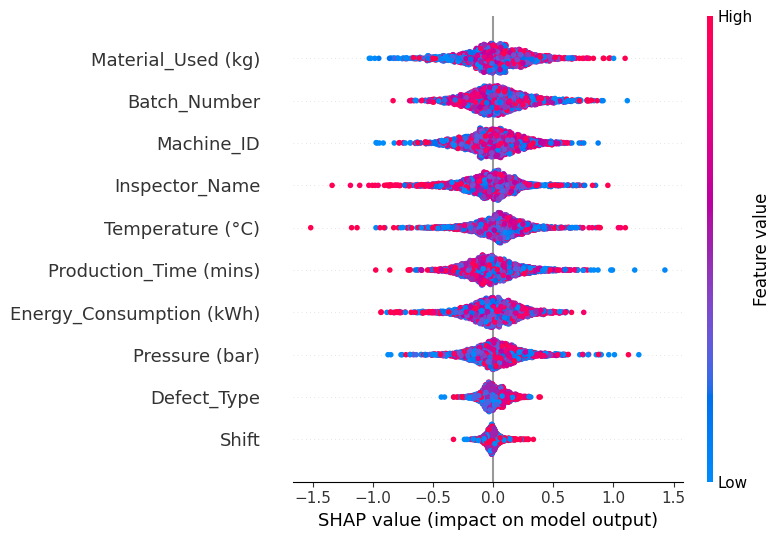

In [15]:
"Use SHAP (SHapley Additive exPlanations) to explain model predictions"
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Evaluate the Model

In [16]:
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[499 495]
 [478 528]]

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.50      0.51       994
           1       0.52      0.52      0.52      1006

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



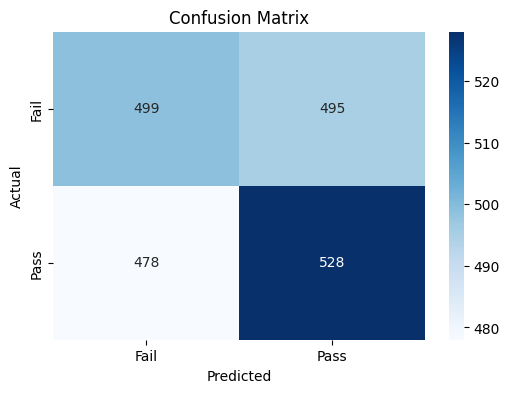

In [17]:
# Visualize the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# model - 2 random forest

In [18]:
# Train the Model
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(random_state=42)
model2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)


Confusion Matrix:
 [[512 482]
 [476 530]]

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.52      0.52       994
           1       0.52      0.53      0.53      1006

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



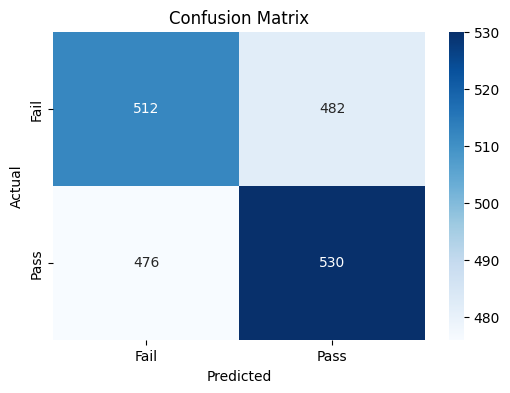

In [19]:
# Evaluate the Model
y_pred = model2.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualizations

<Axes: title={'center': 'Defect Trends Over Time'}, xlabel='Production_Date'>

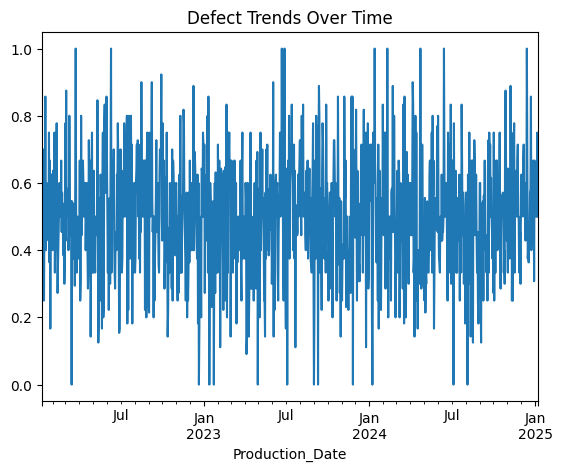

In [20]:
# Defect Trends Over Time:
df.groupby('Production_Date')['Pass_Fail'].mean().plot(title="Defect Trends Over Time")

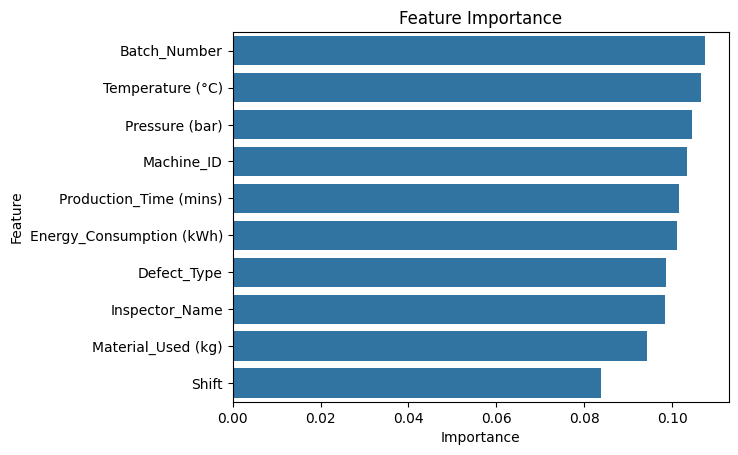

In [21]:
# Feature Importance Plot:
import seaborn as sns
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.title("Feature Importance")
plt.show()

# Prediction Distribution

C:\Users\njhar\AppData\Local\Temp\ipykernel_15780\2491237490.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="coolwarm")


Text(0.5, 1.0, 'Predicted Quality Distribution')

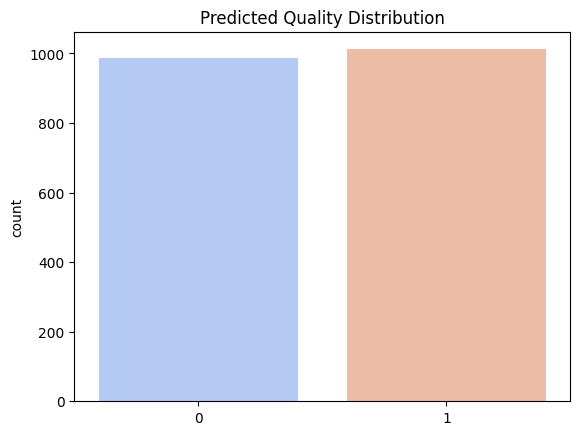

In [22]:
# Prediction Distribution
sns.countplot(x=y_pred, palette="coolwarm")
plt.title("Predicted Quality Distribution")

# Example output for predictions (first 10 records)

In [23]:
# Example output for predictions (first 10 records)
print("\nPredicted Results (First 10 Records):")
for i, pred in enumerate(y_pred[:20]):
    print(f"Sample {i+1}: Prediction={pred}, Actual={y_test.values[i]}")


Predicted Results (First 10 Records):
Sample 1: Prediction=1, Actual=0
Sample 2: Prediction=1, Actual=1
Sample 3: Prediction=1, Actual=1
Sample 4: Prediction=1, Actual=0
Sample 5: Prediction=1, Actual=0
Sample 6: Prediction=0, Actual=0
Sample 7: Prediction=0, Actual=0
Sample 8: Prediction=1, Actual=1
Sample 9: Prediction=1, Actual=0
Sample 10: Prediction=1, Actual=0
Sample 11: Prediction=0, Actual=1
Sample 12: Prediction=0, Actual=0
Sample 13: Prediction=0, Actual=1
Sample 14: Prediction=1, Actual=0
Sample 15: Prediction=0, Actual=1
Sample 16: Prediction=1, Actual=1
Sample 17: Prediction=1, Actual=1
Sample 18: Prediction=1, Actual=0
Sample 19: Prediction=0, Actual=1
Sample 20: Prediction=0, Actual=1
